In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

In [2]:
!unzip archive.zip

Archive:  archive.zip
  inflating: features.csv            
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               


In [3]:
!find . -name ".csv"

In [4]:
df = pd.read_csv('train.csv')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
monthly_sales = (
    df.groupby(pd.Grouper(key='Date', freq='M'))['Weekly_Sales']
      .sum()
      .reset_index()
)

monthly_sales.set_index('Date', inplace=True)
monthly_sales.head()

/tmp/ipython-input-816029984.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='Date', freq='M'))['Weekly_Sales']


,Weekly_Sales
Date,
2010-02-28,1.903330e+08
2010-03-31,1.819198e+08
2010-04-30,2.314124e+08
2010-05-31,1.867109e+08
2010-06-30,1.922462e+08


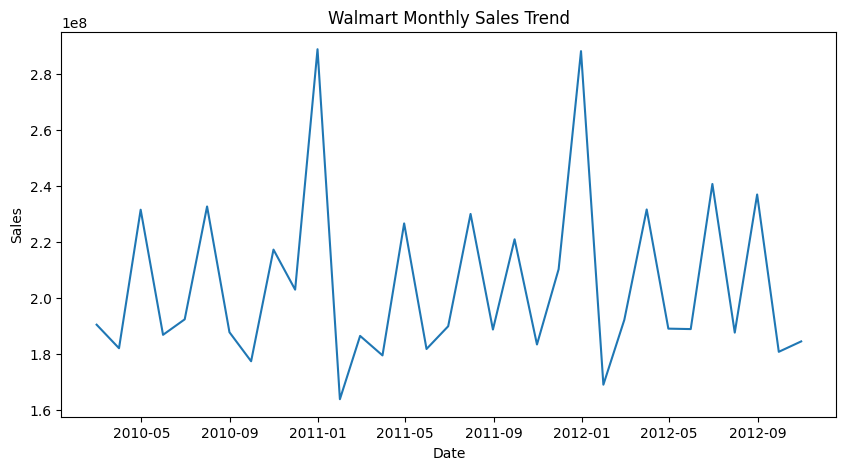

In [8]:
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['Weekly_Sales'])
plt.title('Walmart Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [9]:
train = monthly_sales.iloc[:-6]
test = monthly_sales.iloc[-6:]

In [10]:
model = ExponentialSmoothing(
    train['Weekly_Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
)

fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [11]:
forecast = fit.forecast(len(test))
forecast

,0
2012-05-31,1.832964e+08
2012-06-30,1.911741e+08
2012-07-31,2.311529e+08
2012-08-31,1.889274e+08
2012-09-30,1.788573e+08
2012-10-31,2.190902e+08


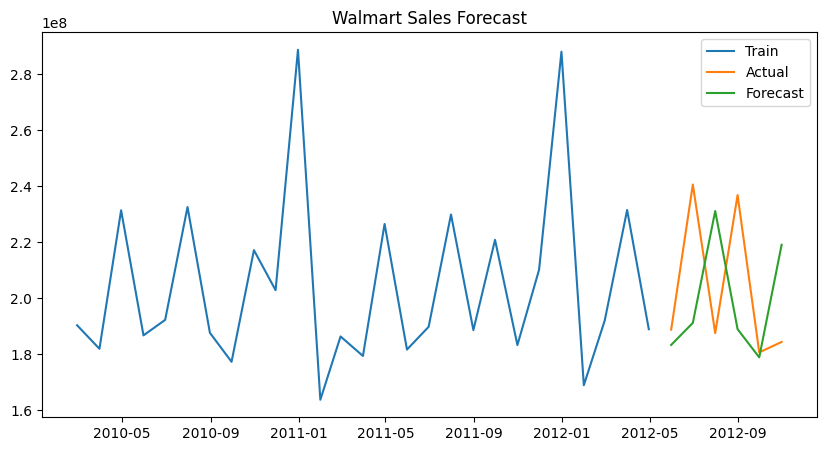

In [12]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train['Weekly_Sales'], label='Train')
plt.plot(test.index, test['Weekly_Sales'], label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title('Walmart Sales Forecast')
plt.show()

In [13]:
mae = mean_absolute_error(test['Weekly_Sales'], forecast)
mape = np.mean(np.abs((test['Weekly_Sales'] - forecast) / test['Weekly_Sales'])) * 100

print("MAE:", mae)
print("MAPE:", mape)

MAE: 30498311.407346193
MAPE: 14.463327387966668


In [14]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_Sales': test['Weekly_Sales'],
    'Forecast_Sales': forecast
})

forecast_df.to_csv('forecast_output.csv', index=False)

In [15]:
with open('forecast_report.txt', 'w') as f:
    f.write(f"""
Walmart Sales Forecasting Report

Dataset: Walmart Train.csv
Model Used: Exponential Smoothing
Forecast Horizon: 6 Months

MAE: {mae}
MAPE: {mape}

Conclusion:
The model captures trend and seasonality effectively and
can be used for demand planning and inventory decisions.
""")